In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rudraksha170 (rudraksha170-indian-institute-of-technology-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: himanshu-singhal (himanshu-singhal-indian-institute-of-technology-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


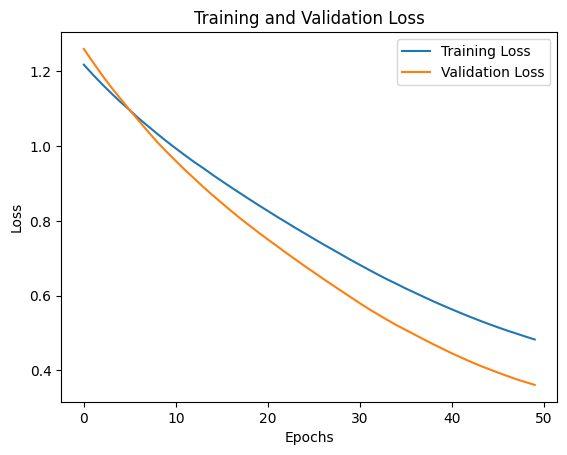

1/1 - 0s - 29ms/step - accuracy: 0.8000 - loss: 0.5053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


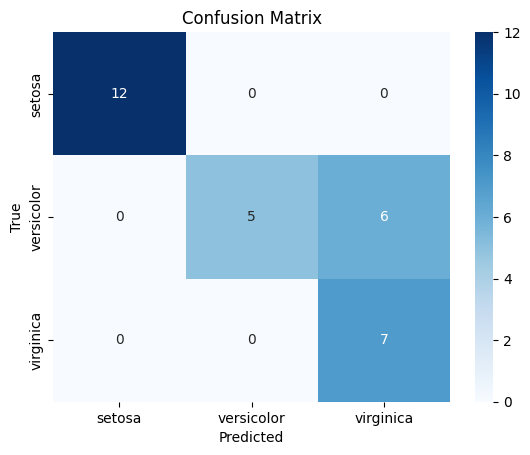

Test Accuracy: 0.800000011920929
Precision: 0.8923076923076924
Recall: 0.8
F1 Score: 0.7925


F1 Score,▁
Precision,▁
Recall,▁
Test Accuracy,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,███▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_loss,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
F1 Score,0.7925
Precision,0.89231
Recall,0.8
Test Accuracy,0.8


In [ ]:
import wandb
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Log in to W&B (this will prompt for login if not already logged in)
wandb.login()

# Initialize Weights & Biases (W&B) experiment tracking
wandb.init(project="iris_mlp_model", config={
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 50,
    "architecture": "MLP with 16 hidden neurons",
    "input_neurons": 4,
    "hidden_neurons": 16,
    "output_neurons": 3
})

# Load the Iris dataset
iris = load_iris()
X = iris.data  # Features
y = iris.target  # Labels

# One-hot encode the labels
y = to_categorical(y, num_classes=3)

# Split the dataset into training (70%), validation (10%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Normalize the feature values to [0, 1] using standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define the MLP model architecture
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(4,)),  # 4 features from the Iris dataset
    tf.keras.layers.Dense(16, activation='relu'),  # Hidden layer with 16 neurons and ReLU activation
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer with 3 neurons (for each class)
])

# Log model architecture to W&B
wandb.config.model_architecture = {
    "input_layer": 4,
    "hidden_layer": 16,
    "output_layer": 3,
    "activation_functions": {
        "hidden_layer": "ReLU",
        "output_layer": "Softmax"
    }
}

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Track training and validation loss
train_loss = []
val_loss = []

# Custom training loop for manual W&B logging
for epoch in range(50):  # 50 epochs
    # Train the model for one epoch
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Append the training and validation loss for the current epoch
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])

    # Log the losses to W&B at the end of each epoch
    wandb.log({
        "epoch": epoch,
        "train_loss": history.history['loss'][0],
        "val_loss": history.history['val_loss'][0]
    })

# Plot the training and validation loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss_curve.png")
plt.show()

# Log loss curve visualization to W&B
wandb.log({"loss_curve": wandb.Image("loss_curve.png")})

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

# Predict the test set labels
y_pred = model.predict(X_test)

# Calculate precision, recall, and F1-score
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix.png")
plt.show()

# Log confusion matrix visualization to W&B
wandb.log({"confusion_matrix": wandb.Image("confusion_matrix.png")})

# Log final evaluation metrics to W&B
wandb.log({
    "Test Accuracy": test_acc,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Confusion Matrix": cm.tolist()  # Convert matrix to list for logging
})

# Print final metrics
print(f"Test Accuracy: {test_acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Finish the W&B experiment
wandb.finish()


In [ ]:
!pip -q install --upgrade scikit-learn scipy numpy

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Batch Size: 2, Learning Rate: 0.001, Epochs: 1, Accuracy: 0.4000, F1 Score: 0.3869
Batch Size: 2, Learning Rate: 0.001, Epochs: 3, Accuracy: 0.7333, F1 Score: 0.7233
Batch Size: 2, Learning Rate: 0.001, Epochs: 5, Accuracy: 0.8000, F1 Score: 0.8000
Batch Size: 2, Learning Rate: 1e-05, Epochs: 1, Accuracy: 0.3667, F1 Score: 0.4035
Batch Size: 2, Learning Rate: 1e-05, Epochs: 3, Accuracy: 0.0000, F1 Score: 0.0000
Batch Size: 2, Learning Rate: 1e-05, Epochs: 5, Accuracy: 0.6000, F1 Score: 0.4647
Batch Size: 4, Learning Rate: 0.001, Epochs: 1, Accuracy: 0.4333, F1 Score: 0.3073
Batch Size: 4, Learning Rate: 0.001, Epochs: 3, Accuracy: 0.7333, F1 Score: 0.7147
Batch Size: 4, Learning Rate: 0.001, Epochs: 5, Accuracy: 0.7333, F1 Score: 0.6619
Batch Size: 4, Learning Rate: 1e-05, Epochs: 1, Accuracy: 0.5000, F1 Score: 0.3824
Batch Size: 4, Learning Rate: 1e-05, Epochs: 3, Accuracy: 0.3000, F1 Score: 0.2267
Batch Size: 4, Learning Rate: 1e-05, Epochs: 5, A

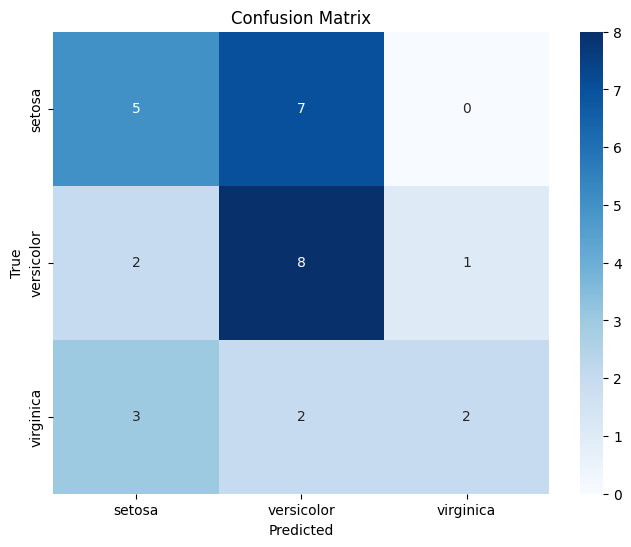

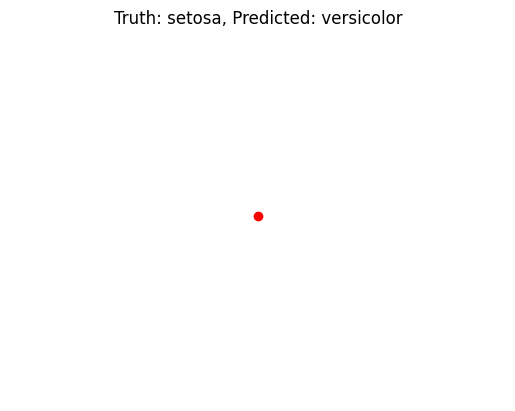

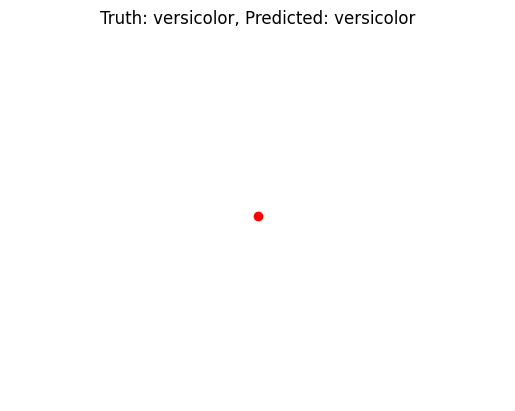

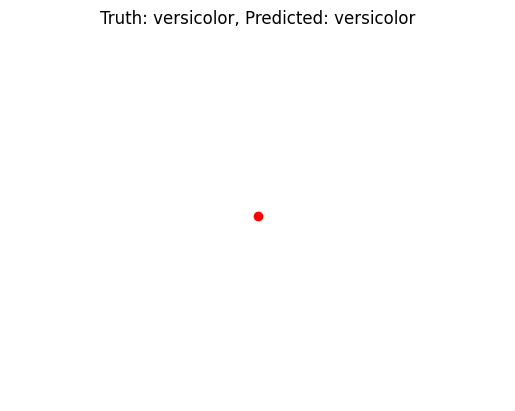

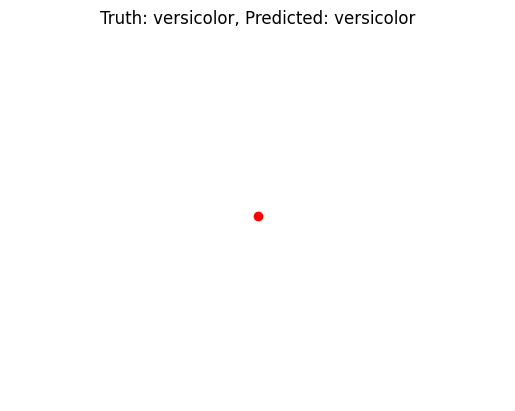

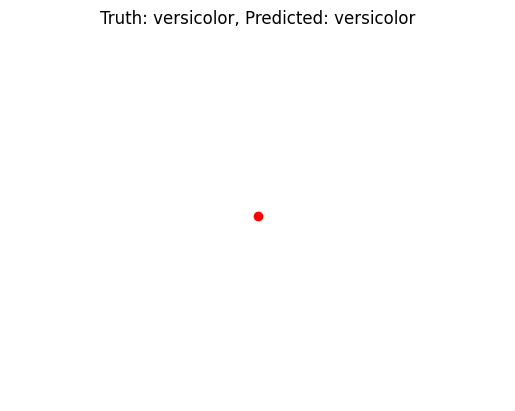

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Define hyperparameters for Task 1
batch_sizes = [2, 4]
learning_rates = [1e-3, 1e-5]
epochs_list = [1, 3, 5]

# Store results
results = []

# Iterate over all combinations of hyperparameters
for batch_size, learning_rate, epochs in itertools.product(batch_sizes, learning_rates, epochs_list):
    # Reinitialize the model
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(4,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    # Store results
    results.append((batch_size, learning_rate, epochs, accuracy, f1))

# Convert results to a structured format for easier plotting
results_array = np.array(results)

# Print results
for result in results:
    print(f"Batch Size: {result[0]}, Learning Rate: {result[1]}, Epochs: {result[2]}, Accuracy: {result[3]:.4f}, F1 Score: {result[4]:.4f}")

# Plot Confusion Matrix for the last model
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Show Sample Inputs, Predictions, and Truth Values
def show_samples(X, y_true, y_pred, num_samples=5):
    indices = np.random.choice(len(X), num_samples, replace=False)
    for i in indices:
        plt.figure()
        plt.scatter(X[i, 0], X[i, 1], c='red', label='Sample')
        plt.title(f'Truth: {iris.target_names[y_true[i]]}, Predicted: {iris.target_names[y_pred[i]]}')
        plt.axis('off')
        plt.show()

show_samples(X_test, y_true_classes, y_pred_classes)

In [9]:
!pip install --upgrade --force-reinstall scikit-learn


  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached numpy-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached numpy-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.5.0
    Uninstalling threadpoolctl-3.5.0:
      Successfully uni

In [1]:
!pip uninstall -y autogluon
!pip install autogluon.tabular

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset
iris = load_iris()
X = iris.data  # Features
y = iris.target  # Labels

# Split the dataset into training (70%), validation (10%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Normalize the feature values using standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Create DataFrames for AutoGluon
train_data = pd.DataFrame(data=np.c_[X_train, y_train], columns=iris.feature_names + ['target'])
test_data = pd.DataFrame(data=np.c_[X_test, y_test], columns=iris.feature_names + ['target'])

# Ensure the target variable is of integer type
train_data['target'] = train_data['target'].astype(int)
test_data['target'] = test_data['target'].astype(int)

# Define the label column
label = 'target'

# Define hyperparameters for different search methods
hyperparameters = {
        'NN_TORCH': {
            'num_epochs': [10, 30, 50],  # Different epoch values
            'learning_rate': [1e-3, 1e-4, 1e-5],  # Various learning rates
            'batch_size': [8, 16, 32],  # Different batch sizes
            'hidden_size': [64, 128, 256],  # Number of neurons in hidden layers
            'dropout_prob': [0.1, 0.3, 0.5],  # Dropout probabilities
        }
    }

# Grid Search
predictor_grid = TabularPredictor(label=label).fit(
    train_data, hyperparameters=hyperparameters, time_limit=600, verbosity=4,
                presets=['optimize_for_deployment', 'medium_quality'],
                raise_on_no_models_fitted=False,
    hyperparameter_tune_kwargs={'search_strategy': 'grid'}
)

print(predictor_grid.model_names)  # Should return a list of trained models
grid_results = predictor_grid.leaderboard(test_data, silent=True)

# Random Search
predictor_random = TabularPredictor(label=label).fit(
    train_data, hyperparameters=hyperparameters, time_limit=600, hyperparameter_tune_kwargs={'search_strategy': 'random', 'num_trials': 5}
)
random_results = predictor_random.leaderboard(test_data, silent=True)

# Hyperband Search
predictor_hyperband = TabularPredictor(label=label).fit(
    train_data, hyperparameters=hyperparameters, time_limit=600, hyperparameter_tune_kwargs={'search_strategy': 'hyperband', 'num_trials': 5}
)
hyperband_results = predictor_hyperband.leaderboard(test_data, silent=True)

# Bayesian Optimization
predictor_bayesian = TabularPredictor(label=label).fit(
    train_data, hyperparameters=hyperparameters, time_limit=600, hyperparameter_tune_kwargs={'search_strategy': 'bayesian', 'num_trials': 5}
)
bayesian_results = predictor_bayesian.leaderboard(test_data, silent=True)

# Combine results into a single DataFrame
results_combined = pd.concat([
    grid_results[['model', 'accuracy', 'f1']].assign(Method='Grid Search'),
    random_results[['model', 'accuracy', 'f1']].assign(Method='Random Search'),
    hyperband_results[['model', 'accuracy', 'f1']].assign(Method='Hyperband'),
    bayesian_results[['model', 'accuracy', 'f1']].assign(Method='Bayesian')
])

# Print final comparison table
print(results_combined)

No path specified. Models will be saved in: "AutogluonModels/ag-20250226_160257"
Verbosity: 4 (Maximum Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       11.38 GB / 12.67 GB (89.8%)
Disk Space Avail:   78.15 GB / 107.72 GB (72.6%)
Presets specified: ['optimize_for_deployment', 'medium_quality']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': False,
 'hyperparameter_tune_kwargs': {'search_strategy': 'grid'},
 'keep_only_best': True,
 'raise_on_no_models_fitted': False,
 'save_space': True,
 'verbosity': 4}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': False,
 'calibrate': 'auto',
 'delay_bag_sets': Fa

<bound method TabularPredictor.model_names of <autogluon.tabular.predictor.predictor.TabularPredictor object at 0x7ed65cd94450>>


AutoGluon training complete, total runtime = 0.14s ... Best model: None


RuntimeError: No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.